# Hyper-parameter Tunning with Genetic Algorithm
### An Example on Tunning Hyper-Parameters for LSTM Time Series Forecasting

> Tianyu Du, Dec. 31, 2018

In this notebook, we will use `GeneticTuner` to generate hyper-parameter sets and find a HP set minimizes the MSE loss on validation set.

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

### Add the project home directory

In [2]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

### Load essential control packages.

In [3]:
import core.genetic.control as control
import core.genetic.tuner as tuner

### Load the LSTM RNN to train.

In [4]:
import core.models.stacked_lstm as stacked_lstm

### Configuration.
### i) Dataset
Use *absolute* path instead of a relative one.

In [5]:
# FILE_DIR = "/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv"
FILE_DIR = "/home/ec2-user/AnnEconForecast/data/UNRATE.csv"

### ii) The Initial Genetic Pool
* **Fixed Genetic Bits**: Use a *single value* to represent a fixed gene bit, each individual in the <u>initial population</u> will have the same gene on those bits.

* **Flexiable Genetic Bits**: Use a *list* to represent a flexiable gene bit, each indivudal in the <u>initial population</u> takes a random element from that list as their own gene value at that bit.

In [6]:
GENE_POOL = {
    # ======== Data Pre-processing Parameter ========
    "PERIODS": 1,
    "ORDER": 1,
    "LAGS": [3, 6, 9, 12],
    "TRAIN_RATIO": 0.8,
    "VAL_RATIO": 0.1,
    # ======== Model Training Parameter ========
    "epochs": [50*x for x in range(1, 21)],
    "num_inputs": 1,
    "num_outputs": 1,
    "num_time_steps": None,  # num_time_steps is identical to LAGS
    "num_neurons": [
        [64] * 2,
        [64] * 3,
        [64] * 4,
        [128] * 2,
        [128] * 3,
        [128] * 4,
        [256] * 2,
        [256] * 3,
        [256] * 4,
        [512] * 2,
        [512] * 3,
        [512] * 4,
        [1024] * 2,
        [1024] * 3,
        [1024] * 4
        
    ],
    "learning_rate": [
        0.1,
        0.03,
        0.01
    ],
    "clip_grad": [None, 50.0, 100.0, 500.0],
    "report_periods": 10
}


### iii) Evoluation
* `TOTAL_GEN`: The total number of generations to evolve.
* `POP_SIZE`: After the selection and breeding phases in each round of evolving, the population size will be mained to this size.
* `RETAIN`: The proportion of population to be retained after selection.
* `SHOT_PROB`: The probability that one individual not selected based on its fittness score to be retained to the next generation.
* `MUTATE_PROB`: The probability to be mutated.
* `IGNORE_SET`: The set of genetic bits to be skipped during mutation and cross-over phases.

In [7]:
# Training Spec.
TOTAL_GEN = 10
POP_SIZE = 10
RETAIN = 0.5
SHOT_PROB = 0.1
MUTATE_PROB = 0.05
IGNORE_SET = (
    "PERIODS", "ORDER", "TRAIN_RATIO", "VAL_RATIO", "num_outputs", "num_inputs", "report_periods"
)

In [8]:
def eval_net_wrapper(param):
    return control.eval_net(
        model=stacked_lstm.StackedLSTM,
        param=param,
        file_dir=FILE_DIR,
        metric="mse_val",
        smooth_metric=0.05
    )

In [9]:
# Create the Optimizer.
optimizer = tuner.GeneticTuner(
    gene_pool=GENE_POOL,
    pop_size=POP_SIZE,
    eval_func=eval_net_wrapper,
    mode="min",
    retain=RETAIN,
    shot_prob=SHOT_PROB,
    mutate_prob=MUTATE_PROB,
    verbose=False,
    ignore=IGNORE_SET
)

### Specify the directory to save elite chromosomes (parameter sets).

In [10]:
# save = "/Users/tianyudu/Downloads/gen"
save = "/home/ec2-user/ga"

In [12]:
start_time = datetime.datetime.now()
elite = control.train_op(
    optimizer=optimizer,
    total_gen=TOTAL_GEN,
    elite=0.5,
    write_to_disk=save
)
end_time = datetime.datetime.now()
print(f"Time taken: {end_time - start_time}")

Generation: [0/10]
Evaluating the initial population.
 ##-------- Evaluating... [2/10,  20.00%] Current Net: size=[1024, 1024], ep=240, lr= 0.0300100

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 ########## Evaluating... [10/10, 100.00%] Current Net: size=[512, 512], ep=60, lr= 0.1000000 0.1000
Best fitted entity validatiton MSE:  0.0318716        
Worst fitted entity validation MSE:  1.1303544
Generation: [1/10]
 ########### Evaluating... [11/11, 100.00%] Current Net: size=[1024, 1024], ep=240, lr= 0.08393151000
Best fitted entity validatiton MSE:  0.0282139        
Worst fitted entity validation MSE:  123.7931900
Time taken: 0:01:00.667802
Generation: [2/10]
 ########### Evaluating... [11/11, 100.00%] Current Net: size=[256, 256, 128], ep=0, lr= 0.10000.10000
Best fitted entity validatiton MSE:  0.0299064        
Worst fitted entity validation MSE:  nan
Time taken: 0:00:51.193867
Generation: [3/10]
 ########## Evaluating... [10/10, 100.00%] Current Net: size=[1024, 1024], ep=150, lr= 0.0298541.0804
Best fitted entity validatiton MSE:  0.0309756        
Worst fitted entity validation MSE:  0.1498127
Time taken: 0:01:20.073769
Generation: [4/10]
 ########### Evaluating... [11/

### The Result.
#### Here is the best-performing chromosome in the latest generation.

In [14]:
(best, score) = list(elite.values())[-1][0]
pprint(best)
print("Validation Set MSE: " + str(score))

{'LAGS': 9,
 'ORDER': 1,
 'PERIODS': 1,
 'TRAIN_RATIO': 0.8,
 'VAL_RATIO': 0.1,
 'clip_grad': None,
 'epochs': 148,
 'learning_rate': 0.360321600530805,
 'num_inputs': 1,
 'num_neurons': [1541, 514],
 'num_outputs': 1,
 'num_time_steps': 9,
 'report_periods': 10}
Validation Set MSE: 0.03584679216146469


### Visualize the Progress
#### We plot the highest, average and lowest *validation set mse loss* in each generation.

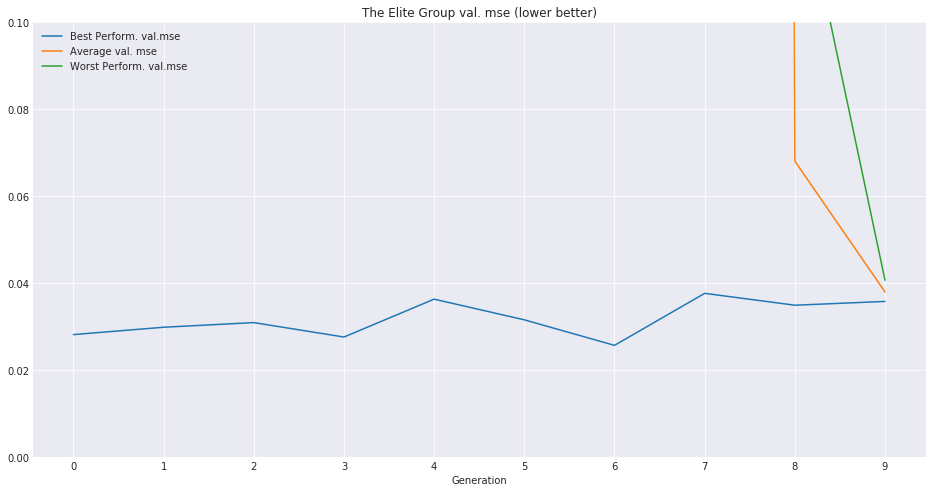

In [17]:
plt.close()
plt.figure(figsize=(16, 8))
plt.style.use('seaborn-dark')
plt.title("The Elite Group val. mse (lower better)")
plt.plot([
    elite_gp[0][1] 
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    np.mean([x[1] for x in elite_gp])
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    elite_gp[-1][1] 
    for elite_gp in list(elite.values())]
)
plt.legend(
    ["Best Perform. val.mse", "Average val. mse", "Worst Perform. val.mse"],
    loc="best"
)
# plt.ylim(0, 0.1)
plt.xlabel("Generation")
plt.xticks(range(TOTAL_GEN))
plt.grid(True)

plt.show()